In [36]:
# ╭────────────────── 0. DEPENDENCIAS BÁSICAS ──────────────────╮
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import rna_utils as ru


DIST_PATH = "../../data/rnadist_f_all.h5"
SIM_PATH = "../../data/seqsim_f_all.h5"
META_PATH = "../../data/sources/ArchiveII_with_prob_and_motiv.csv"

threshold = 100

In [37]:
dist, meta = ru.load_and_align(corr_path=DIST_PATH, meta_path=META_PATH)
sim, meta = ru.load_and_align(corr_path=SIM_PATH, meta_path=META_PATH)

# checks
assert dist.shape == sim.shape
assert (dist.index == dist.columns).all()
assert (sim.index == sim.columns).all()

In [38]:
meta.groupby("fam").sequence.agg("count")

fam
16s             66
23s             15
5s            1283
RNaseP         454
grp1            74
srp            918
tRNA           557
telomerase      35
tmRNA          462
Name: sequence, dtype: int64

In [39]:
def duplicate_ratio(subDF):
    A = subDF.values
    dup = (A == 0).sum() - len(A)  # zeros fuera de la diagonal
    total = len(A) * (len(A) - 1)
    return dup / total


meta.groupby("fam").apply(
    lambda g: duplicate_ratio(dist.loc[g.index, g.index])
).sort_values(ascending=False)

/tmp/ipykernel_221956/3351561183.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meta.groupby("fam").apply(


fam
tRNA          0.041680
5s            0.007245
tmRNA         0.002554
srp           0.001509
RNaseP        0.001507
grp1          0.001111
16s           0.000000
23s           0.000000
telomerase    0.000000
dtype: float64

In [40]:
def duplicate_ratio(subDF):
    A = subDF.values
    dup = (A == 1).sum() - len(A)  # zeros fuera de la diagonal
    total = len(A) * (len(A) - 1)
    return dup / total


meta.groupby("fam").apply(
    lambda g: duplicate_ratio(sim.loc[g.index, g.index])
).sort_values(ascending=False)

/tmp/ipykernel_221956/1703523402.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meta.groupby("fam").apply(


fam
tmRNA         0.001286
grp1          0.001111
srp           0.001048
tRNA          0.000717
RNaseP        0.000360
5s            0.000261
16s           0.000000
23s           0.000000
telomerase    0.000000
dtype: float64

In [41]:
# ╭────────── 2.1 CONSTRUIR SUB-MATRICES INTRA-FAMILIA ──────────╮
fam_corrs = ru.build_intra_fam_corrs(corr=dist, meta=meta)  # {fam: DataFrame}

In [42]:
# ╭────────── 2.2 HELPER: MEIDOIDE DE UN CLÚSTER ──────────╮

def medoid_of_cluster(D, members):
    """
    D          : matriz de distancias (ndarray n,n)
    members    : índices dentro de D que pertenecen al clúster
    Devuelve   : índice  del miembro que minimiza la ∑ distancia.
    """
    if len(members) == 1:
        return members[0]
    sub = D[np.ix_(members, members)]
    return members[sub.sum(axis=1).argmin()]

Familias:   0%|          | 0/9 [00:00<?, ?it/s]

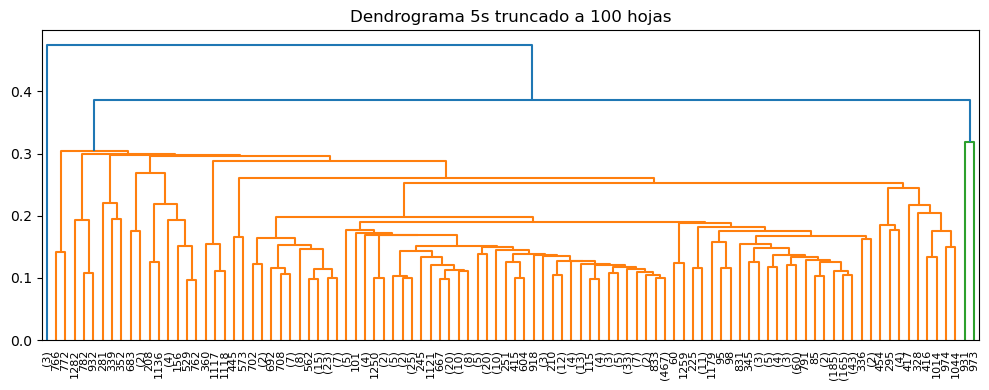

Familias:  33%|███▎      | 3/9 [00:00<00:00,  6.38it/s]

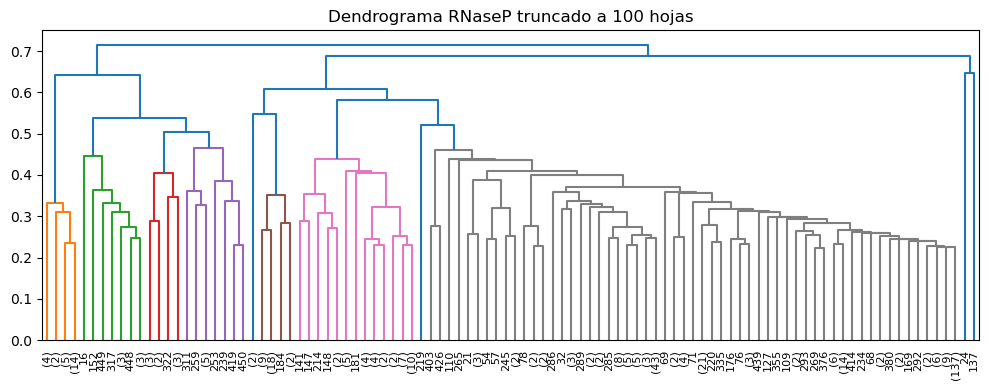

Familias:  44%|████▍     | 4/9 [00:00<00:01,  4.02it/s]

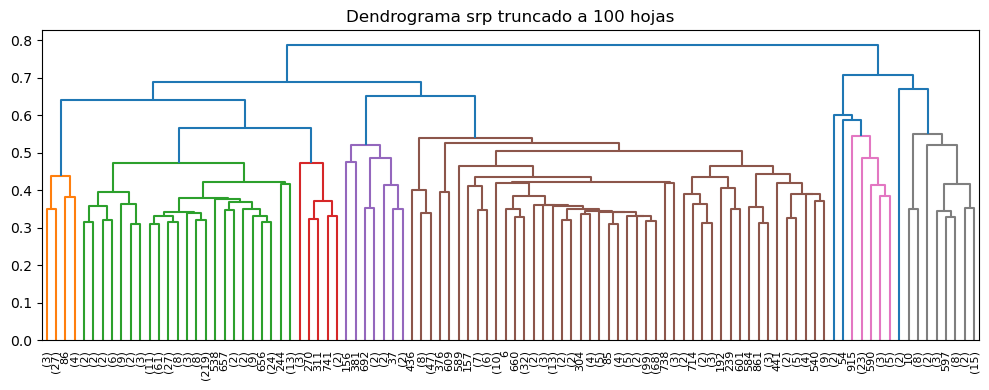

Familias:  67%|██████▋   | 6/9 [00:01<00:00,  3.92it/s]

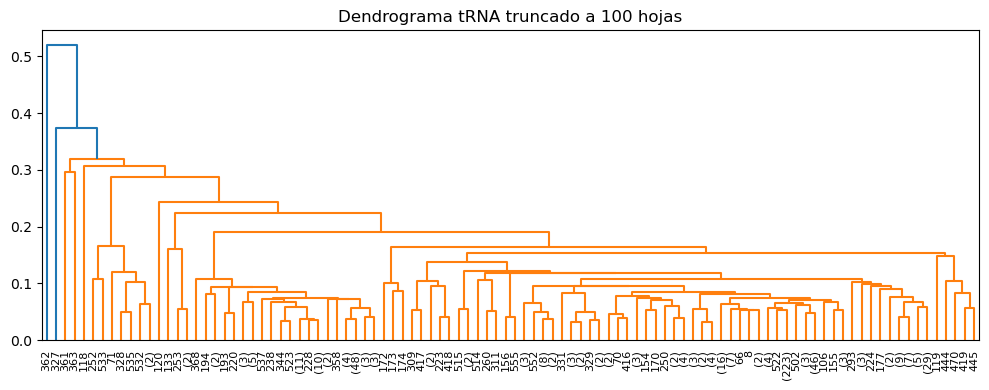

Familias:  78%|███████▊  | 7/9 [00:01<00:00,  3.38it/s]

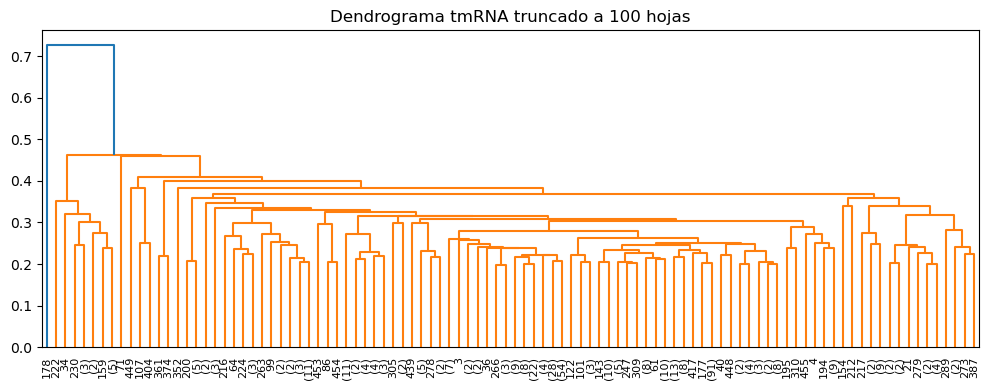

Familias: 100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


In [43]:
# ╭────────── 2.3 LOOP POR FAMILIA → ÍNDICES REPRESENTANTES ──────────╮
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from tqdm import tqdm

rep_idx = []  # IDs (labels) de secuencias elegidas

for fam, intra_familia in tqdm(fam_corrs.items(), desc="Familias"):

    ids = intra_familia.index
    n = len(ids)

    # ——— Familias pequeñas: queda todo ———
    if n <= threshold:
        rep_idx.extend(ids)
        continue

    # ——— Familias grandes: clustering jerárquico ———
    D = intra_familia.values
    Z = linkage(squareform(D, checks=False), method="average")
    labels = fcluster(Z, t=threshold, criterion="maxclust")  
    # ╭────────── 7. VISUALIZACIÓN BÁSICA DEL DENDROGRAMA ───────────╮
    plt.figure(figsize=(10, 4))
    dendrogram(
        Z,
        truncate_mode="lastp",
        p=threshold,
        show_leaf_counts=True,
        leaf_rotation=90,
        leaf_font_size=8,
        color_threshold=None,
    )
    plt.title(f"Dendrograma {fam} truncado a {threshold} hojas")
    plt.tight_layout()
    plt.show()
    # Medoide por clúster
    for k in np.unique(labels):
        members_local = np.where(labels == k)[0]
        rep_local = medoid_of_cluster(D, members_local)
        rep_idx.append(ids[rep_local])

In [44]:
# ╭────────── 2.4 ARMAR NUEVO DATASET REDUCIDO ──────────╮
rep_idx = pd.Index(rep_idx, name="id")
dist_red = dist.loc[rep_idx, rep_idx].copy()  # matriz de distancias
sim_red = sim.loc[rep_idx, rep_idx].copy()  # matriz de similitud
meta_red = meta.loc[rep_idx].copy()  # metadatos filtrados

print("Shape dist_red :", dist_red.shape)
print("Familias       :", meta_red["fam"].value_counts())

Shape dist_red : (690, 690)
Familias       : fam
5s            100
tmRNA         100
RNaseP        100
tRNA          100
srp           100
grp1           74
16s            66
telomerase     35
23s            15
Name: count, dtype: int64


In [45]:
meta_red.to_csv(f"../../data/filtered_dataset/ArchiveII_hclus_{threshold}.csv", index=True)